In [ ]:
!pip install gensim
!pip install scikit-learn
!pip install matplotlib
!pip install scikit-learn
!pip install umap


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px
import random
import string
regex_punctuation = '[' + string.punctuation + ']'

# Preprocessing

## Load the data

This is the first part of our notebook, where we're setting up the data that we'll be working with throughout our exploration of word embeddings. Word embeddings are a way of representing text where similar words have a similar representation, which is beneficial in many natural language processing tasks. Specifically, we're going to be working with the SQUAD 2.0 dataset.

The SQuAD 2.0 dataset, which stands for Stanford Question Answering Dataset, is a popular dataset in the field of Natural Language Processing. It is composed of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage.

The data is stored in JSON format, which is a common, lightweight data-interchange format that is easy for humans to read and write and easy for machines to parse and generate. The 'load_data' function is defined to read this JSON data from the given file path.

In [ ]:
import json
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_data = load_data('train-v2.0.json')
dev_data = load_data('dev-v2.0.json')


## Extract Text and Questions

This part of the notebook is dedicated to extracting the specific data we need from the SQuAD 2.0 dataset. We're interested in the contexts (the passages that the questions are about), the questions themselves, and the answers to these questions.

Remember that in SQuAD 2.0, every question is about a specific passage, and the answer to the question is always a segment of the passage. Also note that in SQuAD 2.0, some questions are marked as 'impossible', meaning they don't have an answer in the associated context.

In the following code we iterate over the data and extract the context passages, questions, and answers (if available). We create separate lists for contexts, questions, and answers.

In [ ]:
def extract_text_and_questions(data):
    contexts = []
    questions = []
    answers = []

    for article in data:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                if qa['is_impossible']:
                    answer = ''
                else:
                    answer = qa['answers'][0]['text']

                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = extract_text_and_questions(train_data)
dev_contexts, dev_questions, dev_answers = extract_text_and_questions(dev_data)


## Clean the text

Normalize the text by lowercasing, removing special characters, and expanding contractions

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]+", " ", text)
    text = re.sub(regex_punctuation,'',text)
    # Add more preprocessing steps if necessary
    return text.strip()

train_contexts = [clean_text(context) for context in train_contexts]
train_questions = [clean_text(question) for question in train_questions]
train_answers = [clean_text(answer) for answer in train_answers]
dev_contexts = [clean_text(context) for context in dev_contexts]
dev_questions = [clean_text(question) for question in dev_questions]
dev_answers = [clean_text(answer) for answer in dev_answers]


## Tokenize the text

Tokenize the context passages and questions into words or subwords, depending on the embeddings you plan to use.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_text(text):
    return word_tokenize(text)

train_contexts_tokenized = [tokenize_text(context) for context in train_contexts]
train_questions_tokenized = [tokenize_text(question) for question in train_questions]
train_answers_tokenized = [tokenize_text(answer) for answer in train_answers]
dev_contexts_tokenized = [tokenize_text(context) for context in dev_contexts]
dev_questions_tokenized = [tokenize_text(question) for question in dev_questions]
dev_answers_tokenized = [tokenize_text(answer) for answer in dev_answers]

tokenized_sentences = train_contexts_tokenized + train_questions_tokenized + train_answers_tokenized


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Convert tokens to indices

Create a vocabulary from the tokens in the training data and map each token to a unique index.

In [ ]:
from collections import Counter
import itertools

def build_vocabulary(tokenized_texts, min_count=5):
    vocab_counter = Counter(itertools.chain(*tokenized_texts))
    vocab = {word: idx + 1 for idx, (word, count) in enumerate(vocab_counter.items()) if count >= min_count}
    vocab['<PAD>'] = 0
    return vocab

vocabulary = build_vocabulary(train_contexts_tokenized + train_questions_tokenized)


## Replace tokens with indices

Replace the tokens in the context passages and questions with their corresponding indices from the vocabulary.

In [ ]:
def tokens_to_indices(tokenized_text, vocab):
    return [vocab.get(token, 0) for token in tokenized_text]

train_contexts_indices = [tokens_to_indices(context, vocabulary) for context in train_contexts_tokenized]
train_questions_indices = [tokens_to_indices(question, vocabulary) for question in train_questions_tokenized]
dev_contexts_indices = [tokens_to_indices(context, vocabulary) for context in dev_contexts_tokenized]
dev_questions_indices = [tokens_to_indices(question, vocabulary) for question in dev_questions_tokenized]


## Pad sequences

Pad the sequences of indices to have equal length for both context passages and questions. You can choose a fixed maximum length or calculate the length based on the distribution of sequence lengths in your dataset.

In [ ]:
from keras_preprocessing.sequence import pad_sequences

def pad_sequences_to_length(sequences, max_length):
    return pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post', value=0)

max_context_length = 300  # You can choose this value based on your dataset
max_question_length = 30  # You can choose this value based on your dataset

train_contexts_padded = pad_sequences_to_length(train_contexts_indices, max_context_length)
train_questions_padded = pad_sequences_to_length(train_questions_indices, max_question_length)
dev_contexts_padded = pad_sequences_to_length(dev_contexts_indices, max_context_length)
dev_questions_padded = pad_sequences_to_length(dev_questions_indices, max_question_length)


# Pre-Trained Embeddings

## Word2Vec

The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular vector. The vectors are chosen carefully such that they capture the semantic and syntactic qualities of words; as such, a simple mathematical function (cosine similarity) can indicate the level of semantic similarity between the words represented by those vectors.

In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)
print(f"Vocabulary size of the Word2Vec Model: {len(model.wv)}")
print("Vocabulary with occurrences:")
vocab = model.wv.key_to_index
vocab

Vocabulary size of the Word2Vec Model: 71784
Vocabulary with occurrences:


{'the': 0,
 'of': 1,
 'and': 2,
 'in': 3,
 'to': 4,
 'a': 5,
 'is': 6,
 'as': 7,
 'was': 8,
 'for': 9,
 'by': 10,
 's': 11,
 'that': 12,
 'with': 13,
 'on': 14,
 'from': 15,
 'are': 16,
 'what': 17,
 'which': 18,
 'or': 19,
 'it': 20,
 'were': 21,
 'at': 22,
 'an': 23,
 'be': 24,
 'this': 25,
 'not': 26,
 'have': 27,
 'has': 28,
 'his': 29,
 'also': 30,
 'its': 31,
 'their': 32,
 'who': 33,
 'other': 34,
 'had': 35,
 'one': 36,
 'first': 37,
 'but': 38,
 'new': 39,
 'such': 40,
 'he': 41,
 'many': 42,
 'most': 43,
 'they': 44,
 'did': 45,
 'when': 46,
 'been': 47,
 'more': 48,
 'city': 49,
 'some': 50,
 'after': 51,
 'all': 52,
 'can': 53,
 'during': 54,
 'into': 55,
 'used': 56,
 'two': 57,
 'than': 58,
 'states': 59,
 'time': 60,
 'world': 61,
 'between': 62,
 'these': 63,
 'there': 64,
 'state': 65,
 'century': 66,
 'may': 67,
 'only': 68,
 'united': 69,
 'over': 70,
 'year': 71,
 '1': 72,
 'war': 73,
 'would': 74,
 'people': 75,
 'known': 76,
 'where': 77,
 'while': 78,
 'how': 79,

In [ ]:
term = 'man'
model.wv.most_similar(term)

[('destiny', 0.722305953502655),
 ('phaedo', 0.7060685157775879),
 ('misfortune', 0.7034206986427307),
 ('suggestion', 0.6828519105911255),
 ('scyld', 0.68064945936203),
 ('signature', 0.665759265422821),
 ('atticus', 0.663584291934967),
 ('oberhauser', 0.657062828540802),
 ('montalb', 0.6549080610275269),
 ('innocence', 0.6494990587234497)]

In [ ]:
import plotly.express as px

sample = random.sample(list(model.wv.key_to_index), 100)
colours = ['man', 'woman', 'king', 'queen', 'red','green','blue','yellow']

word_vectors = model.wv[sample + colours]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

r = (-500,500)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 100)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## glove-wiki-gigaword-200

The use of GloVe embeddings pretrained on the Wikipedia 2014 + Gigaword 5 dataset (glove-wiki-gigaword-200) can be highly beneficial for the task of question answering on the SQuAD 2.0 dataset. These embeddings have been trained on a massive corpus of 6 billion tokens, capturing rich semantic and syntactic information about words. This pretraining process allows us to leverage a vast amount of linguistic knowledge that can't be gleaned from the SQuAD dataset alone. Furthermore, with 200 dimensions, these embeddings strike a balance between capturing meaningful word relationships and maintaining a manageable computational load. This is particularly important for question answering tasks, where understanding nuanced word meanings and relationships can be key to correctly answering questions. Given that the SQuAD 2.0 dataset and the GloVe pretraining corpus both contain a wide range of topics and language styles, these embeddings are likely to provide a good general-purpose representation for the words in our task. Moreover, using pretrained embeddings can speed up the training process, as the model doesn't need to learn word representations from scratch. Hence, glove-wiki-gigaword-200 provides an effective, efficient, and practical choice of word embeddings for question answering on SQuAD 2.0.

In [ ]:
pip install gensim

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-200")

[==================================================] 100.0% 252.1/252.1MB downloaded


In [ ]:
print(f"Vocabulary size wikipedia model: {len(model_wiki)}")

Vocabulary size wikipedia model: 400000


In [ ]:
term = 'politecnico'
print(f'Wikipedia embedding: {model_wiki.most_similar(term)}')

Wikipedia embedding: [('milano', 0.6039094924926758), ('triennale', 0.5342872738838196), ('università', 0.5341924428939819), ('pontificia', 0.509983241558075), ('istituto', 0.49387848377227783), ('certosa', 0.4828879237174988), ('scuola', 0.47788673639297485), ('laurea', 0.4768095910549164), ('di', 0.4735192358493805), ('normale', 0.47024768590927124)]


## Wikipedia 2014 + Gigaword 5

https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec'
glove2word2vec(glove_file, word2vec_output_file)

from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


/tmp/ipykernel_511/1793543059.py:5: DeprecationWarning:

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).



## Experiments & Visualisations

### Most similar words

In [ ]:
# Find the most similar words to a given word
similar_words = model.most_similar('king', topn=10)
print(similar_words)

# Solve word analogies
analogy = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print(analogy)


[('prince', 0.7682328820228577), ('queen', 0.7507690787315369), ('son', 0.7020888328552246), ('brother', 0.6985775232315063), ('monarch', 0.6977890729904175), ('throne', 0.6919989585876465), ('kingdom', 0.6811409592628479), ('father', 0.6802029013633728), ('emperor', 0.6712858080863953), ('ii', 0.6676074266433716)]
[('queen', 0.7698540687561035)]


### PCA

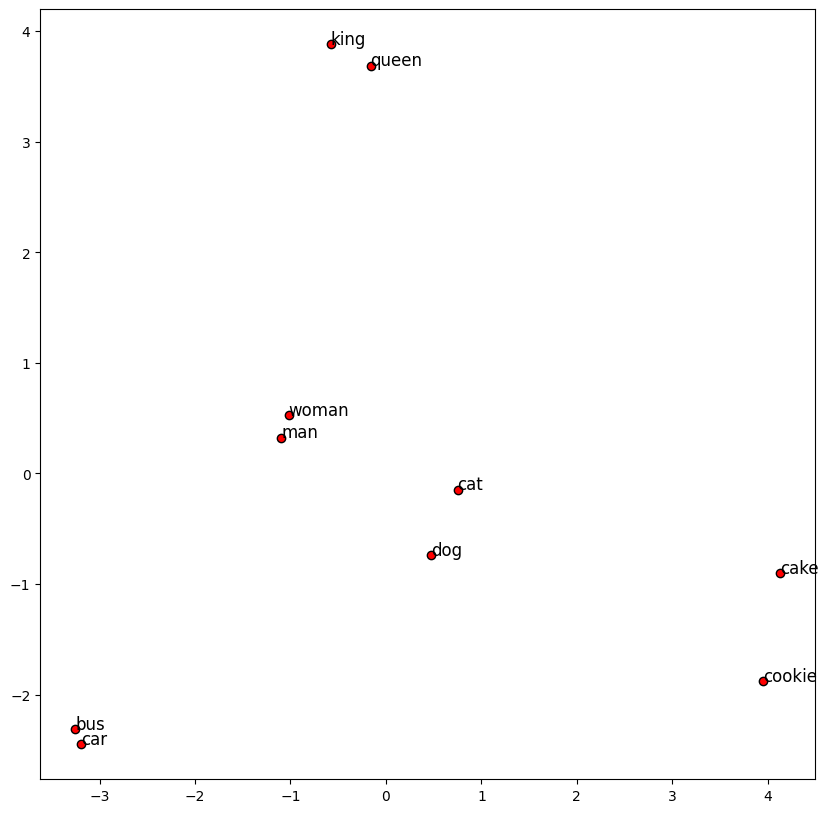

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(words, model):
    word_vectors = np.array([model[word] for word in words])
    pca = PCA(n_components=2)
    word_vectors_2d = pca.fit_transform(word_vectors)

    plt.figure(figsize=(10, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, word_vectors_2d):
        plt.text(x, y, word, fontsize=12)

    plt.show()

# Choose interesting words for visualization
words = ['king', 'queen', 'man', 'woman', 'dog', 'cat', 'car', 'bus', 'cake', 'cookie']

plot_pca(words, model)


### UMAP

In [ ]:
!/root/venv/bin/python -m pip install --upgrade pip
!pip install umap

/root/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/root/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/root/venv/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the '

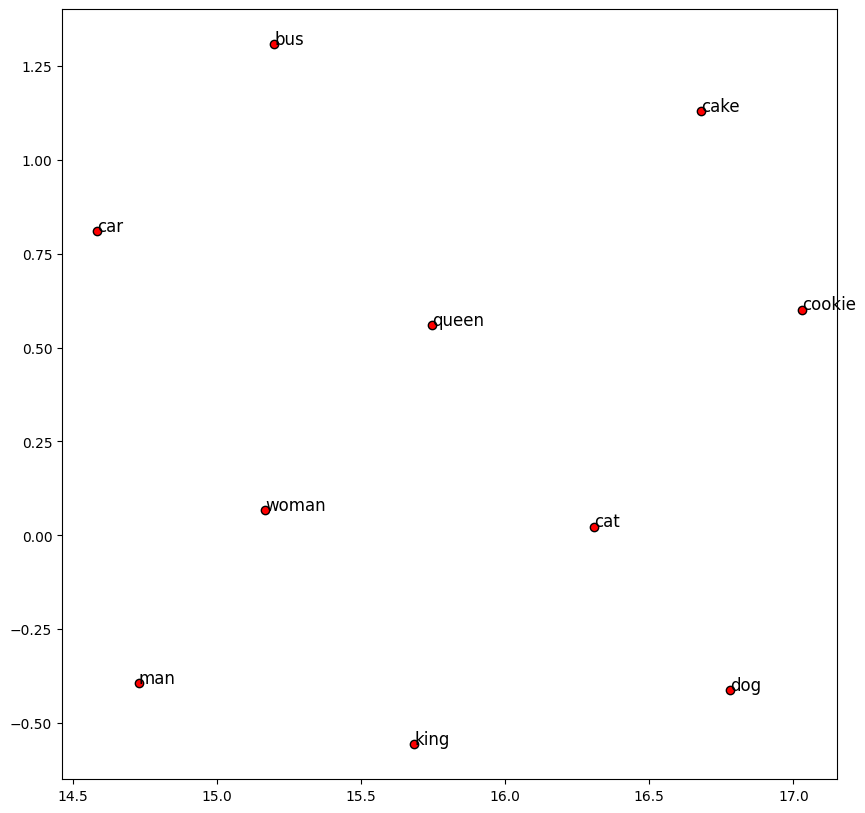

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

def plot_umap(words, model):
    word_vectors = np.array([model[word] for word in words])
    reducer = umap.UMAP()
    word_vectors_2d = reducer.fit_transform(word_vectors)

    plt.figure(figsize=(10, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, word_vectors_2d):
        plt.text(x, y, word, fontsize=12)

    plt.show()

# Install the umap-learn library
!pip install umap-learn

# Choose interesting words for visualization
words = ['king', 'queen', 'man', 'woman', 'dog', 'cat', 'car', 'bus', 'cake', 'cookie']

plot_umap(words, model)


### MDS

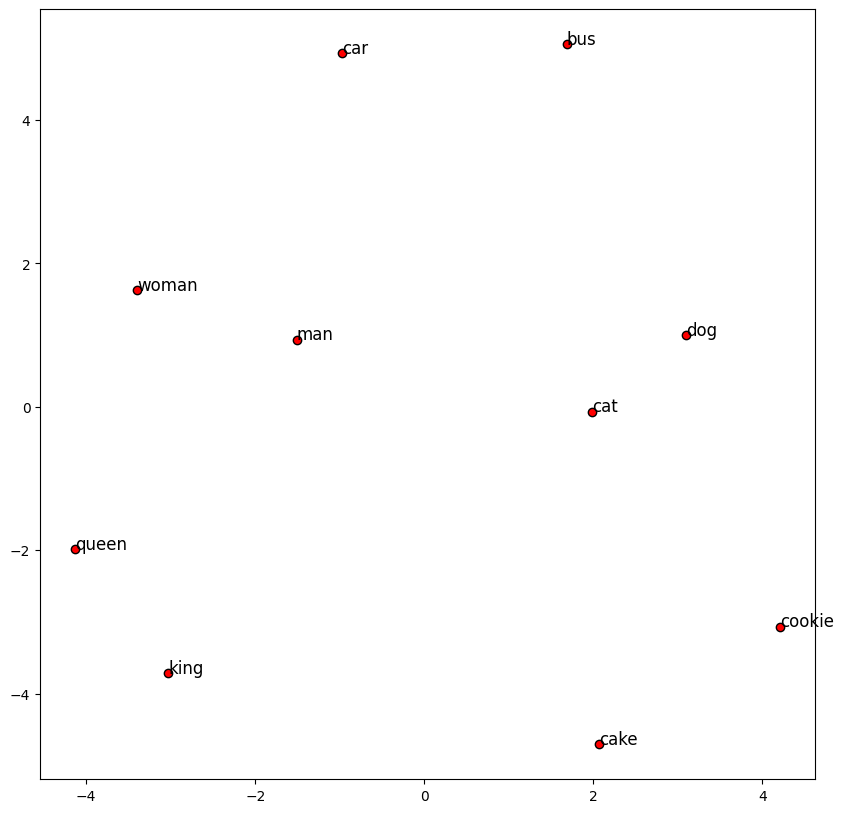

In [ ]:
from sklearn.manifold import MDS

def plot_mds(words, model):
    word_vectors = np.array([model[word] for word in words])
    mds = MDS(n_components=2, random_state=42)
    word_vectors_2d = mds.fit_transform(word_vectors)

    plt.figure(figsize=(10, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, word_vectors_2d):
        plt.text(x, y, word, fontsize=12)

    plt.show()

words = ['king', 'queen', 'man', 'woman', 'dog', 'cat', 'car', 'bus', 'cake', 'cookie']

plot_mds(words, model)


### Heatmap

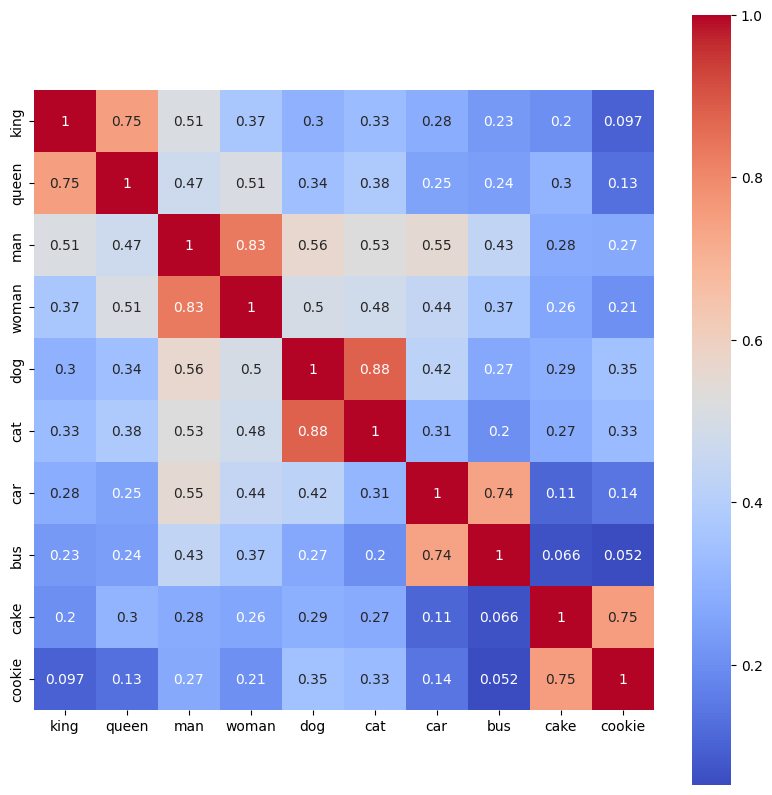

In [ ]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def plot_heatmap(words, model):
    word_vectors = np.array([model[word] for word in words])
    distance_matrix = squareform(pdist(word_vectors, metric='cosine'))

    plt.figure(figsize=(10, 10))
    sns.heatmap(1 - distance_matrix, annot=True, xticklabels=words, yticklabels=words, cmap='coolwarm', square=True)
    plt.show()

# Install seaborn library
!pip install seaborn

words = ['king', 'queen', 'man', 'woman', 'dog', 'cat', 'car', 'bus', 'cake', 'cookie']

plot_heatmap(words, model)


# Custom Embedding

Training word embeddings such as Word2Vec on the SQuAD dataset can be beneficial for a few key reasons:

Domain-Specific Knowledge: While pre-trained embeddings like GloVe or Word2Vec trained on a large generic corpus are excellent at capturing general language usage patterns, they may not fully capture the nuances of a specific dataset or domain. The SQuAD dataset contains a diverse set of topics from various domains, and training embeddings on this data can help capture the unique semantic and syntactic relationships present within the dataset. This is especially useful if there are unique words or phrases in the SQuAD dataset that are not well-represented in the pre-trained embeddings.

Fine-Tuning: Training Word2Vec on the SQuAD data would allow the embeddings to learn more about the specific task of question answering. Words that often appear close together in the context of a question and answer pair might develop more similar embeddings, which could improve the model's performance on this specific task.

Performance Improvement: Task-specific embeddings can sometimes lead to performance improvements. While this isn't guaranteed (and depends on factors like the size of your dataset and the complexity of your task), it's possible that SQuAD-specific embeddings could outperform more generic embeddings for the task of question answering on the SQuAD dataset.

Interpretability: Training your own embeddings can provide more interpretability. By looking at the words that a trained Word2Vec model considers similar, you can gain insights into what the model has learned about your specific task and dataset.

In [ ]:
!pip install requests

In [ ]:
import requests
# Load SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
r = requests.get(url)
squad_dataset_train = r.json()

# Load SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'
r = requests.get(url)
squad_dataset_dev = r.json()

texts = []
labels = []
answers = [] 
questions = []

# Extract contexts, questions, and labels (answerable or unanswerable)
for article in squad_dataset_train['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            questions.append(question)
            if qa['is_impossible']:
                label = 0
                answer_text = ""  # For unanswerable questions, we set the answer text to an empty string
            else:
                label = 1
                answer_text = qa['answers'][0]['text']  # Extract the plain text of the first answer
            texts.append(context)
            labels.append(label)
            answers.append(answer_text)  # Add the answer text to the answers list

for article in squad_dataset_dev['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            questions.append(question)
            if qa['is_impossible']:
                label = 0
                answer_text = ""  # For unanswerable questions, we set the answer text to an empty string
            else:
                label = 1
                answer_text = qa['answers'][0]['text']  # Extract the plain text of the first answer
            texts.append(context)
            labels.append(label)
            answers.append(answer_text)  # Add the answer text to the answers list



In this section we learn word embeddings using the Word2Vec implementation provided by the gensim package. 

- Information on gensim's word2vec implementation is available here: https://radimrehurek.com/gensim/models/word2vec.html

- First install the package using pip:

In [ ]:
!pip install --upgrade gensim

In order to train Word2Vec on the data we first need to convert it to the right format. 

- For training Word2Vec, it is usual to separate data into individual sentences and then tokenize those sentences separately

- So let's use regular expressions to remove the end-of-line characters from each document and then split the documents into sentences using a regular expression that looks for question marks, exclamation marks, and periods, followed by a space: 

In [ ]:
import re

# remove newline characters
docs = [re.sub('\n', ' ', doc) for doc in texts]
# remove email addresses
docs = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in docs]
# split sentences 
sentences = [re.split('[?!.]\s', doc) for doc in docs] # Search for a dot/question mark/ ... followed by a space
sentences[:2]

[['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
  "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child",
  "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time",
  'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'],
 ['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
  "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the lat

Above, we've printed out the first two documents, which have been split into arrays of sentences. 

- We'll need to flatten the structure into one big array of sentences (remove the distinction between documents) before providing it to Word2Vec

- We can do that using the flatten command from the pandas library:

In [ ]:
from pandas.core.common import flatten

sentences = list(flatten(sentences)) # flatten the list of lists => Drop the document level => Single list of sentences (starting point for word2vec)
sentences[:20]

['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time",
 'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s

Now we can proceed to do some cleaning of the data: 

- Remove non-letter characters from each sentence 

- Lowercase 

- Tokenize the sentences based on whitespace

- Remove any sentence with length less than 2 since it won't be useful for training Word2Vec. 

In [ ]:
# remove everything that is not a word character (a-z, A-Z, 0-9, _), and replace it with a space
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]  # split() splits the string into a list of words using the space as a delimiter
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

# Prints a list of lists, where each list contains the words of a sentence
for sentence in tokenized_sentences[:10]:
    print(sentence)

['beyoncé', 'giselle', 'knowles', 'carter', 'biːˈjɒnseɪ', 'bee', 'yon', 'say', 'born', 'september', '4', '1981', 'is', 'an', 'american', 'singer', 'songwriter', 'record', 'producer', 'and', 'actress']
['born', 'and', 'raised', 'in', 'houston', 'texas', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'r', 'b', 'girl', 'group', 'destiny', 's', 'child']
['managed', 'by', 'her', 'father', 'mathew', 'knowles', 'the', 'group', 'became', 'one', 'of', 'the', 'world', 's', 'best', 'selling', 'girl', 'groups', 'of', 'all', 'time']
['their', 'hiatus', 'saw', 'the', 'release', 'of', 'beyoncé', 's', 'debut', 'album', 'dangerously', 'in', 'love', '2003', 'which', 'established', 'her', 'as', 'a', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'awards', 'and', 'featured', 'the', 'billboard', 'hot', '100', 'number', 'one', 'singles', 'crazy', 'in', '

Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set: 

- The embedding size to be 50

- The minimum count for any vocabulary term to be 5

- The size of the context window to 15

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=50, min_count=5, window=15) # 50 dimensional vectors representing the words, only words that appear at least 5 times (document frequency), window size of 15 words

Let's see how big the vocabulary is that Word2Vec ended up using, i.e. how many word vectors did it learn:

In [ ]:
len(model.wv)

74962

Now that we have a word2vec model trained, what can we do with it? Let's print out one of the vectors to see what it looks like:

In [ ]:
term = 'car'
model.wv[term]

array([ 1.4057854 , -2.1017942 ,  2.3771884 , -0.11172199, -0.6716694 ,
        1.3182495 ,  0.02647114,  1.7925608 , -1.1595004 ,  1.4994367 ,
       -1.0888586 ,  2.6575332 ,  1.6658558 , -1.3932428 ,  5.1010404 ,
        0.09905625,  0.3932567 ,  1.5291551 , -4.6952415 , -2.3866205 ,
       -0.7713858 , -0.88832706,  1.5102764 , -3.9837854 , -1.5931028 ,
       -1.7565279 , -2.4415007 ,  0.05991187, -2.1586754 ,  2.7571816 ,
        2.8626056 ,  0.66365343, -0.96356374,  0.6371648 ,  0.61278194,
       -1.788444  ,  0.5122749 ,  3.842277  ,  0.7269195 , -5.685967  ,
       -2.851994  ,  1.398399  , -0.43602127,  3.8054905 ,  2.0671456 ,
        2.2473712 , -0.12810978,  0.20839599, -1.4686391 , -4.4969916 ],
      dtype=float32)

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.

In [ ]:
term ='germany'

model.wv.most_similar(term)

[('austria', 0.698914647102356),
 ('france', 0.6842014193534851),
 ('german', 0.66480553150177),
 ('poland', 0.6541202068328857),
 ('sweden', 0.651121199131012),
 ('russia', 0.6308513879776001),
 ('netherlands', 0.6273631453514099),
 ('europe', 0.6187655925750732),
 ('pact', 0.6026210188865662),
 ('finland', 0.5984763503074646)]

We'll now visualise some of the word vectors in a 3 dimensional space using t-SNE.

- The vocabulary of word vectors is quite large. Giving them all to t-SNE will cause it to take far too long to converge.

- So let's first choose a random subset of 500 terms to show:

In [ ]:
import random

sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)

['deities', 'quanshu', 'forsyth', 'ebrard', 'arnaldo', 'cleves', '提督', 'zenger', 'madeira', 'gobierno', 'shotguns', 'philhellenism', 'corrales', 'plazas', 'coyne', 'srauta', 'denies', 'lotte', 'kenadid', 'hagnau', 'pointe', 'raze', 'clergymen', 'biologized', 'beyonceae', 'bovines', 'javed', 'takayuki', 'algarves', 'lice', 'transalpine', 'invalidation', 'ascertainable', 'halasi', 'pines', 'ethanol', 'warming', 'gallicans', 'archduke', 'arrows', 'rivalled', 'assignment', 'heaven', 'prettanikē', 'marcia', 'virilis', 'seiu', 'avanti', 'interweave', 'airlines', 'wallis', 'tended', 'beriberi', 'hora', 'litharge', 'sensors', 'gael', 'calvaria', 'c6h12o6', 'muon', 'spoils', 'equinut', 'polyandrous', 'duchies', 'kinburn', 'pastures', 'bonobos', 'cleisthenes', 'westons', 'aeruginosa', 'reinterred', 'offerings', 'telemedicine', 'bə', 'rincon', 'histórico', 'ceased', 'upheaval', 'pertained', 'barons', 'holiness', 'storyland', 'anyathian', 'paraphrase', 'addon', 'finite', 'theotokopoulos', 'socieda

Now we'll get the word vectors for the sampled terms:

In [ ]:
word_vectors = model.wv[sample]
word_vectors

array([[-3.6450094e-01,  1.1140982e+00, -2.0396852e+00, ...,
        -1.0641223e+00, -8.1686580e-01,  1.6877880e+00],
       [-7.2274797e-02,  2.2671638e-01, -1.6491029e-01, ...,
         2.9243818e-01,  4.5870757e-01, -1.4052826e-03],
       [-1.9870740e-01,  9.1534175e-02,  2.3983259e-01, ...,
        -2.8703633e-01,  7.6506150e-01,  5.8923614e-01],
       ...,
       [ 7.2723113e-02,  2.0141682e-01,  1.5242557e-01, ...,
        -2.6552173e-01, -7.0381188e-01,  2.9405621e-01],
       [-1.5977351e-01,  1.1426939e-01, -2.7846945e-02, ...,
        -1.0241737e-01, -2.3486938e-02, -1.6134655e-01],
       [-2.3949277e-01,  5.6194082e-02, -2.1940286e-01, ...,
        -5.3112692e-01,  2.4688372e-01,  1.8496047e-01]], dtype=float32)

And we'll provide the vectors to TSNE to fit a model and transform the data to 3 dimensions:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Now transform the data into 3 columns (for x, y, and z):

In [ ]:
import numpy as np

x, y, z = np.transpose(tsne_embedding)

And generate the 3d plot:

In [ ]:
!pip install plotly
import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Let's extend the random set of terms with a set of colours to see if they cluster:

In [ ]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = model.wv[colours+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



# Intrinsic evaluation

Intrinsic evaluators test the quality of a representation independent of specific natural language processing tasks. They measure syntactic or semantic relationships between word directly. 

https://www.cl.uni-heidelberg.de/courses/ss19/emb/material/evaluation.pdf

##  Word Analogy

Given a pair of words A and B and a third word C, the analogy relationship between A and B can be used to find the corresponding word D to C. One example could be write : writing --> read : reading or Rome : Italy --> Paris : France

https://arxiv.org/abs/1901.09785

Datasets for intrinsic word vector evaluation for the word analogy: http://download.tensorflow.org/data/questions-words.txt

In [ ]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import torch

#glove_wiki_gigaword_50 = api.load("glove-wiki-gigaword-50")
#glove_wiki_gigaword_100 = api.load("glove-wiki-gigaword-100")
#glove_wiki_gigaword_150 = api.load("glove-wiki-gigaword-200")
glove_wiki_gigaword_200 = api.load("glove-wiki-gigaword-300")
#glove_twitter_25 = api.load("glove-twitter-25")
#glove_twitter_50 = api.load("glove-twitter-50")
#glove_twitter_100 = api.load("glove-twitter-100")
#glove_twitter_200 = api.load("glove-twitter-200")
fasttext_wiki_news_subwords_300 = api.load("fasttext-wiki-news-subwords-300")
#word2vec_ruscorpora_300 = api.load("word2vec-ruscorpora-300")
word2vec_google_news_300 = api.load("word2vec-google-news-300")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
word1 = 'man'
word2 = 'king'
word3 = 'woman'

print("Example of Word Analogy with the our models")
print("Analogy man : king --> woman : queen")
print("glove_wiki_gigaword_50 man : king --> woman : ", glove_wiki_gigaword_50.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_wiki_gigaword_100 man : king --> woman : ", glove_wiki_gigaword_100.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_wiki_gigaword_150 man : king --> woman : ", glove_wiki_gigaword_150.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_wiki_gigaword_200 man : king --> woman : ", glove_wiki_gigaword_200.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_twitter_25 man : king --> woman : ", glove_twitter_25.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_twitter_50 man : king --> woman : ", glove_twitter_50.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_twitter_100 man : king --> woman : ", glove_twitter_100.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("glove_twitter_200 man : king --> woman : ", glove_twitter_200.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("fasttext_wiki_news_subwords_300 man : king --> woman : ", fasttext_wiki_news_subwords_300.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("word2vec_ruscorpora_300 man : king --> woman : ", word2vec_ruscorpora_300.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])
print("word2vec_google_news_300 man : king --> woman : ", word2vec_google_news_300.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0])

Some example of analogies from the dataset used for the evaluation:

In [ ]:
import random

file_path = '/work/Word vector analogies.txt'
num_lines = 10 

with open(file_path, "r") as file:
    lines = file.readlines()
    
    if len(lines) >= num_lines:
        random_lines = random.sample(lines, num_lines)
        for line in random_lines:
            if line.startswith(": "):
                continue
            print(line, end='')

The models try to solve the analogies whose words they know in their vocabulary. We then keep track of the number of analogies evaluated and the number of resolutions correct for semantics and syntax.

In [ ]:
file_path = '/work/Word vector analogies.txt'

number_evaluated_analogies_glove_wiki_gigaword_200 = 0
number_correct_analogies_glove_wiki_gigaword_200 = 0
number_evaluated_analogies_glove_6B_100d = 0
number_correct_analogies_glove_6B_100d = 0

with open(file_path, "r") as file:
    #for line in file:
    for _ in range(500):
        line = file.readline()
        if line.startswith(": "):
            continue
        words = line.lower().split()
        if all(word in glove_wiki_gigaword_200.key_to_index  for word in words[:4]):
            result_analogy = glove_wiki_gigaword_200.most_similar(positive=[words[0], words[2]], negative=[words[1]], topn=1)[0][0]
            number_evaluated_analogies_glove_wiki_gigaword_200 += 1
            if result_analogy == words[3]:
                number_correct_analogies_glove_wiki_gigaword_200 += 1
        if all(word in glove_6B_100d.key_to_index  for word in words[:4]):
            result_analogy = glove_6B_100d.most_similar(positive=[words[0], words[2]], negative=[words[1]], topn=1)[0][0]
            number_evaluated_analogies_glove_6B_100d += 1
            if result_analogy == words[3]:
                number_correct_analogies_glove_6B_100d += 1


Accuracy of analogy solutions by model (number of correct/total solutions):

In [ ]:
accuracy_glove_wiki_gigaword_200 = number_correct_analogies_glove_wiki_gigaword_200/number_evaluated_analogies_glove_wiki_gigaword_200*100
print(f"The model glove_wiki_gigaword_200 correctly resolved {accuracy_glove_wiki_gigaword_200:.2f} % of the evaluated analogies")
accuracy_glove_6B_100d = number_correct_analogies_glove_6B_100d/number_evaluated_analogies_glove_6B_100d*100
print(f"The model accuracy_glove_6B_100d correctly resolved {accuracy_glove_6B_100d:.2f} % of the evaluated analogies")

## Word Similarity

The word similarity evaluator correlates the distance between word vectors and human perceived semantic similarity.
The goal is to measure how well the notion of human perceived similarity is captured by the word vector representations. Similarity consists of scoring word pairs. Each pair is human-labelled with a score representing the compatibility between the concepts of the pair.

The evaluation relies on measuring the Spearman correlation between labelled scores and reconstructed scores from the
word embedding. The reconstructed scores are obtained by taking the cosine similarity between pairs. The correlation score constitutes in the end the value of the evaluation. https://aclanthology.org/2020.lrec-1.589.pdf

In [ ]:
print("Example of Word Similarity with the our models")
print("Similarity between money and cash")
print("glove_wiki_gigaword_200 ", glove_wiki_gigaword_200.most_similar('money', topn=3))
print("glove_6B_100d ", glove_6B_100d.most_similar('money', topn=3))

### WordSim353 dataset

Some example of similarities from the dataset WordSim353 (http://alfonseca.org/eng/research/wordsim353.html) used for the evaluation with tuples of terms and their human perceived semantic similarity. The range of the scale for the human perceived semantic similarity is [0-10]. In this dataset there are mainly synonymy (common words).

In [ ]:
import random

file_path = '/work/wordsim_similarity_goldstandard.txt'
num_lines = 10 

print("1° term | 2° term | Human perceived semantic similarity")

with open(file_path, "r") as file:
    lines = file.readlines()
    
    if len(lines) >= num_lines:
        random_lines = random.sample(lines, num_lines)
        for line in random_lines:
            if line.startswith(": "):
                continue
            print(line, end='')

We calculate for each pair of words present in the dataset the cosine similairy of the embeddings of the two words produced by the model

In [ ]:
file_path = '/work/wordsim_similarity_goldstandard.txt'

similarity_glove_wiki_gigaword_200 =[[],[]]
number_evaluated_similarities_glove_wiki_gigaword_200 = 0
similarity_glove_6B_100d =[[],[]]
number_evaluated_similarities_glove_6B_100d = 0

with open(file_path, "r") as file:
    for line in file:
        words = line.lower().split()
        if all(word in glove_wiki_gigaword_200.key_to_index  for word in words[:2]):
            if(len(words) != 3):
                continue
            human_semantic_similarity = float(words[2])
            similarity_glove_wiki_gigaword_200[0].append(human_semantic_similarity)
            cosine_similarity = glove_wiki_gigaword_200.cosine_similarities(glove_wiki_gigaword_200[words[0]], [glove_wiki_gigaword_200[words[1]]])[0]
            similarity_glove_wiki_gigaword_200[1].append(cosine_similarity)
            number_evaluated_similarities_glove_wiki_gigaword_200 += 1
        if all(word in glove_6B_100d.key_to_index  for word in words[:2]):
            if(len(words) != 3):
                continue
            human_semantic_similarity = float(words[2])
            similarity_glove_6B_100d[0].append(human_semantic_similarity)
            cosine_similarity = glove_6B_100d.cosine_similarities(glove_6B_100d[words[0]], [glove_6B_100d[words[1]]])[0]
            similarity_glove_6B_100d[1].append(cosine_similarity)
            number_evaluated_similarities_glove_6B_100d += 1


The evaluation relies on measuring the Spearman correlation between human perceived scores and reconstructed scores from the
word embedding.

The Spearman coefficient, or Spearman's rank correlation coefficient, is a non-parametric measure of correlation used to assess the monotonic relationship between two variables. It is based on the ranks of the observations rather than their actual values. The Spearman coefficient can range from -1 to 1, where:

1 indicates a perfect positive monotonic correlation, meaning that as one variable increases, the other variable also increases.
-1 indicates a perfect negative monotonic correlation, meaning that as one variable increases, the other variable decreases.
0 indicates no monotonic correlation between the variables.

In [ ]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(similarity_glove_wiki_gigaword_200[0], similarity_glove_wiki_gigaword_200[1])
print("Number of evaluated similarities with glove_wiki_gigaword_200: ", number_evaluated_similarities_glove_wiki_gigaword_200)
print(f"Spearman Correlation for the glove_wiki_gigaword_200 {corr:.2f}")
corr, p_value = spearmanr(similarity_glove_6B_100d[0], similarity_glove_6B_100d[1])
print("Number of evaluated similarities with glove_6B_100d: ", number_evaluated_similarities_glove_6B_100d)
print(f"Spearman Correlation for the glove_6B_100d {corr:.2f}")

We can try with another dataset, SimVerb-3500: A Large-Scale Evaluation Set of Verb Similarity.  The range of the scale for the human perceived semantic similarity is [0-10]. https://github.com/benathi/word2gm/tree/master/evaluation_data/simverb/data

In [ ]:
import random

file_path = '/work/SimVerb-3500.txt'
num_lines = 10 

print("1° term | 2° term | POS tag | Rating | Relation of the pair")

with open(file_path, "r") as file:
    lines = file.readlines()
    
    if len(lines) >= num_lines:
        random_lines = random.sample(lines, num_lines)
        for line in random_lines:
            if line.startswith(": "):
                continue
            print(line, end='')

We calculate for each pair of words present in the dataset the cosine similairy of the embeddings of the two words produced by the model

In [ ]:
file_path = '/work/SimVerb-3500.txt'

similarity_glove_wiki_gigaword_200 =[[],[]]
number_evaluated_similarities_glove_wiki_gigaword_200 = 0
similarity_glove_6B_100d =[[],[]]
number_evaluated_similarities_glove_6B_100d = 0

with open(file_path, "r") as file:
    for line in file:
        words = line.lower().split()
        if ((words[0] in glove_wiki_gigaword_200.key_to_index) and (words[1] in glove_wiki_gigaword_200.key_to_index)):
            if(len(words) != 5):
                continue
            human_semantic_similarity = float(words[3])
            similarity_glove_wiki_gigaword_200[0].append(human_semantic_similarity)
            cosine_similarity = glove_wiki_gigaword_200.cosine_similarities(glove_wiki_gigaword_200[words[0]], [glove_wiki_gigaword_200[words[1]]])[0]
            similarity_glove_wiki_gigaword_200[1].append(cosine_similarity)
            number_evaluated_similarities_glove_wiki_gigaword_200 += 1
        if ((words[0] in glove_6B_100d.key_to_index) and (words[1] in glove_6B_100d.key_to_index)):
            if(len(words) != 5):
                continue
            human_semantic_similarity = float(words[3])
            similarity_glove_6B_100d[0].append(human_semantic_similarity)
            cosine_similarity = glove_6B_100d.cosine_similarities(glove_6B_100d[words[0]], [glove_6B_100d[words[1]]])[0]
            similarity_glove_6B_100d[1].append(cosine_similarity)
            number_evaluated_similarities_glove_6B_100d += 1


The evaluation relies on measuring the Spearman correlation between human perceived scores and reconstructed scores from the
word embedding.

In [ ]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(similarity_glove_wiki_gigaword_200[0], similarity_glove_wiki_gigaword_200[1])
print("Number of evaluated similarities with glove_wiki_gigaword_200: ", number_evaluated_similarities_glove_wiki_gigaword_200)
print(f"Spearman Correlation for the glove_wiki_gigaword_200 {corr:.2f}")
corr, p_value = spearmanr(similarity_glove_6B_100d[0], similarity_glove_6B_100d[1])
print("Number of evaluated similarities with glove_6B_100d: ", number_evaluated_similarities_glove_6B_100d)
print(f"Spearman Correlation for the glove_6B_100d {corr:.2f}")

### Card-660 dataset

We can try with another dataset, Card-660: Cambridge Rare Word Dataset. Card-660 is a challenging, yet reliable, benchmark for the evaluation of subword and rare word representation techniques.  The range of the scale for the human perceived semantic similarity is [0-4]. https://pilehvar.github.io/card-660/

In [ ]:
import random

file_path = '/work/Card-660.txt'
num_lines = 10 

print("1° term | 2° term | Rating")

with open(file_path, "r") as file:
    lines = file.readlines()
    
    if len(lines) >= num_lines:
        random_lines = random.sample(lines, num_lines)
        for line in random_lines:
            if line.startswith(": "):
                continue
            print(line, end='')

We calculate for each pair of words present in the dataset the cosine similairy of the embeddings of the two words produced by the model

In [ ]:
file_path = '/work/Card-660.txt'

similarity_glove_wiki_gigaword_200 =[[],[]]
number_evaluated_similarities_glove_wiki_gigaword_200 = 0
similarity_glove_6B_100d =[[],[]]
number_evaluated_similarities_glove_6B_100d = 0

with open(file_path, "r") as file:
    for line in file:
        words = line.lower().split()
        if all(word in glove_wiki_gigaword_200.key_to_index  for word in words[:2]):
            if(len(words) != 3):
                continue
            human_semantic_similarity = float(words[2])
            similarity_glove_wiki_gigaword_200[0].append(human_semantic_similarity)
            cosine_similarity = glove_wiki_gigaword_200.cosine_similarities(glove_wiki_gigaword_200[words[0]], [glove_wiki_gigaword_200[words[1]]])[0]
            similarity_glove_wiki_gigaword_200[1].append(cosine_similarity)
            number_evaluated_similarities_glove_wiki_gigaword_200 += 1
        if all(word in glove_6B_100d.key_to_index  for word in words[:2]):
            if(len(words) != 3):
                continue
            human_semantic_similarity = float(words[2])
            similarity_glove_6B_100d[0].append(human_semantic_similarity)
            cosine_similarity = glove_6B_100d.cosine_similarities(glove_6B_100d[words[0]], [glove_6B_100d[words[1]]])[0]
            similarity_glove_6B_100d[1].append(cosine_similarity)
            number_evaluated_similarities_glove_6B_100d += 1


The evaluation relies on measuring the Spearman correlation between human perceived scores and reconstructed scores from the
word embedding.

In [ ]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(similarity_glove_wiki_gigaword_200[0], similarity_glove_wiki_gigaword_200[1])
print("Number of evaluated similarities with glove_wiki_gigaword_200: ", number_evaluated_similarities_glove_wiki_gigaword_200)
print(f"Spearman Correlation for the glove_wiki_gigaword_200 {corr:.2f}")
corr, p_value = spearmanr(similarity_glove_6B_100d[0], similarity_glove_6B_100d[1])
print("Number of evaluated similarities with glove_6B_100d: ", number_evaluated_similarities_glove_6B_100d)
print(f"Spearman Correlation for the glove_6B_100d {corr:.2f}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=43adf7e0-69c2-458a-bdc9-81a8ce3733f2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>